<div style="text-align:center;">
  <span style="color:#962323; font-size:45px; font-weight:bold; font-family:Arial;">Flood Prediction</span>
</div>

### <span style="color:#800080; font-style:italic; font-family:Arial;">General import</span>

In [1]:
ON_KAGGLE = False

In [2]:
if ON_KAGGLE:
    !pip install seaborn --upgrade --quiet
else:
    import sys
    sys.path.append('..')
    %load_ext autoreload
    %autoreload 2

import utilities

import os
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

COLORS = utilities.ColorGenerator.COLORS

train_path = 'train.csv' if not ON_KAGGLE else ''
test_path  = 'test.csv' if not ON_KAGGLE else ''

BASE_XGB = True
BASE_CAT = True
BASE_LGB = True

In [3]:
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

assert not df_train.empty
assert not df_test.empty
assert df_train.columns[:-1].equals(df_test.columns)

In [4]:
print('_______Train_______')
df_train.head(3)

_______Train_______


,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530


In [5]:
print('_______Test_______')
df_test.head(3)

_______Test_______


,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3


In [6]:
df_train.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

### <span style="color:#800080; font-style:italic; font-family:Arial;">First analysis</span>

In [7]:
df_train.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [8]:
df_test.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
count,7.453050e+05,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,...,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000,745305.000000
mean,1.490609e+06,4.915610,4.930288,4.960027,4.946084,4.938424,4.933524,4.958468,4.927651,4.945308,...,4.947436,4.944003,4.957209,4.927620,4.930720,4.926062,4.926957,4.948424,4.940204,4.943918
std,2.151512e+05,2.056295,2.094117,2.071722,2.052602,2.081816,2.059243,2.089312,2.068110,2.073404,...,2.081322,2.072335,2.088787,2.079006,2.083348,2.065638,2.073692,2.065891,2.079128,2.087387
min,1.117957e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.304283e+06,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,...,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,3.000000
50%,1.490609e+06,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,1.676935e+06,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,1.863261e+06,16.000000,17.000000,16.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,...,16.000000,17.000000,17.000000,16.000000,16.000000,17.000000,19.000000,22.000000,16.000000,16.000000


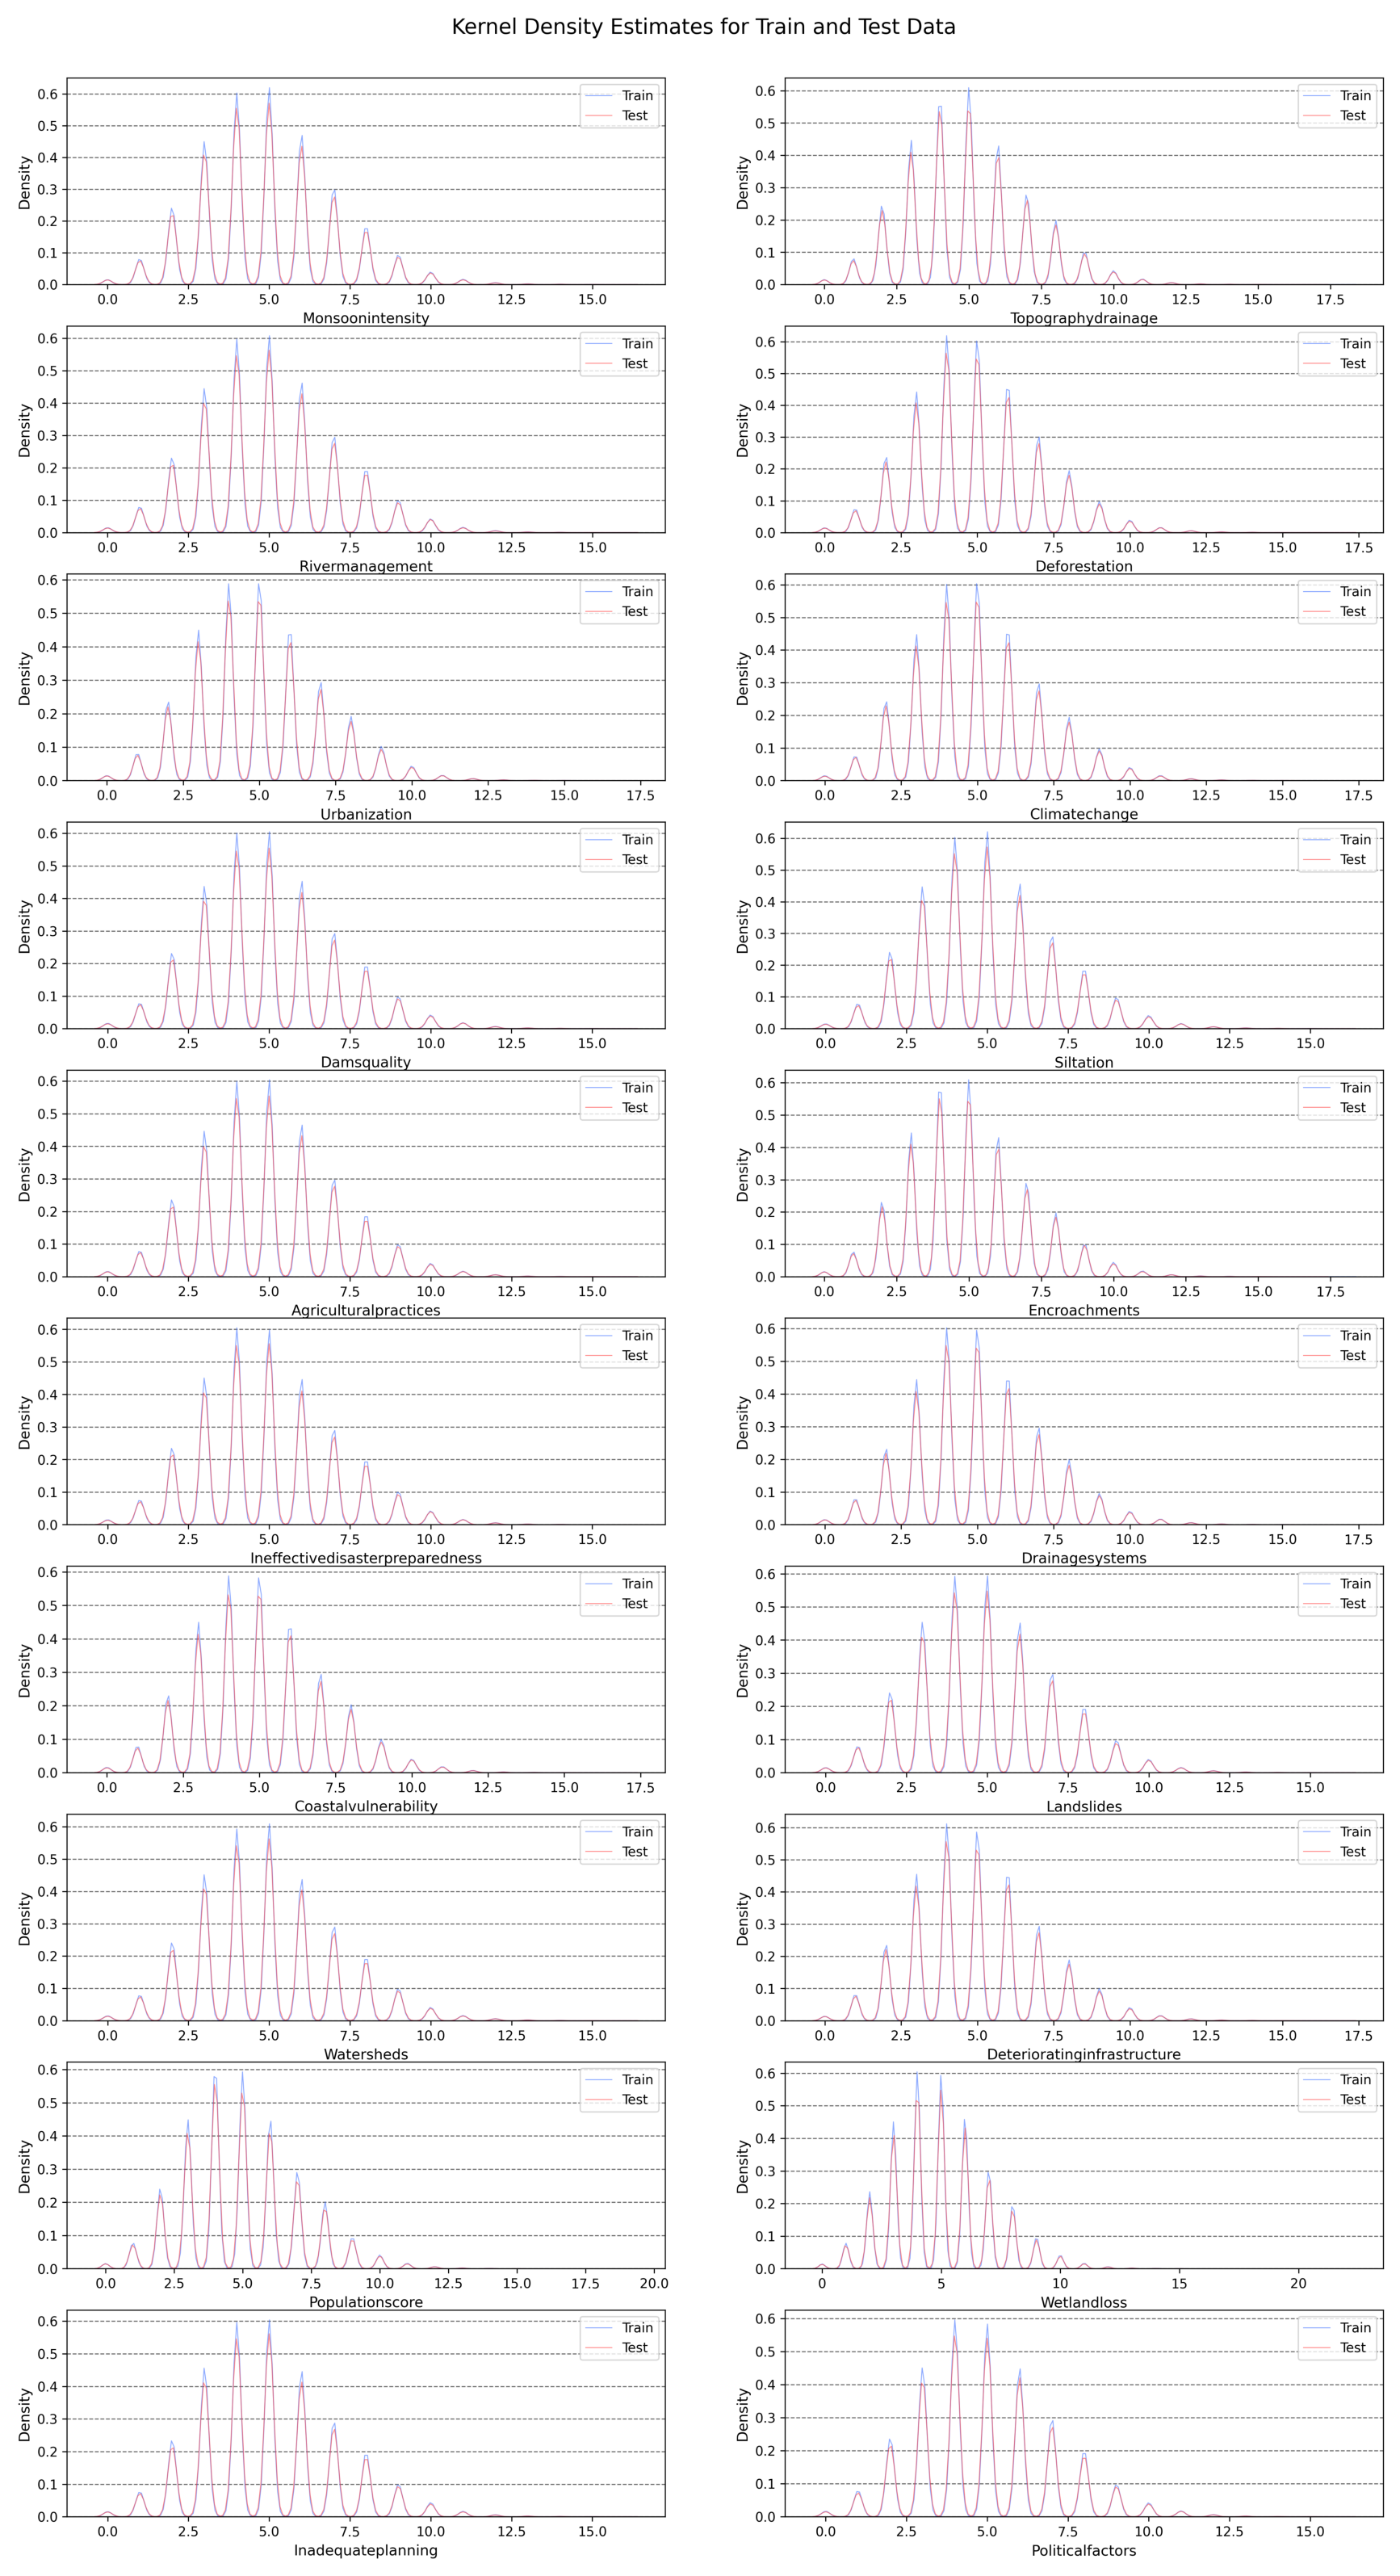

In [9]:
image_path = './img/kde_train_test.png'

plt.figure(figsize=(18, 32))

if not os.path.exists(image_path):
    col_to_plot = df_test.drop(columns= ['id'], axis=1).columns

    plt.suptitle('Kernel Density Estimates for Train and Test Data', fontsize=16, y=1.02)
    plt.subplots_adjust(top=1)

    for i, col in enumerate(col_to_plot):
        ax = plt.subplot(len(col_to_plot) // 2 + 1, 2, i + 1)
        utilities.plot_kde(ax, [df_train, df_test], column=col, color=[COLORS['BLUE'], COLORS['RED']], labels=['Train', 'Test'])

    plt.savefig(image_path, bbox_inches='tight', dpi=300)

else:
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

The distribution of train and test data are identical so no need to rebalance data

Now we check if there is any missing data in the dataset:

In [10]:
pd.DataFrame([df_train.isnull().sum(), df_test.isnull().sum()], index=['TRAIN', 'TEST']).T

,TRAIN,TEST
id,0.0,0.0
MonsoonIntensity,0.0,0.0
TopographyDrainage,0.0,0.0
RiverManagement,0.0,0.0
Deforestation,0.0,0.0
Urbanization,0.0,0.0
ClimateChange,0.0,0.0
DamsQuality,0.0,0.0
Siltation,0.0,0.0
AgriculturalPractices,0.0,0.0


There are no missing values in the dataset, so we can proceed with the analysis.

### <span style="color:#800080; font-style:italic; font-family:Arial;">Data Analysis</span>

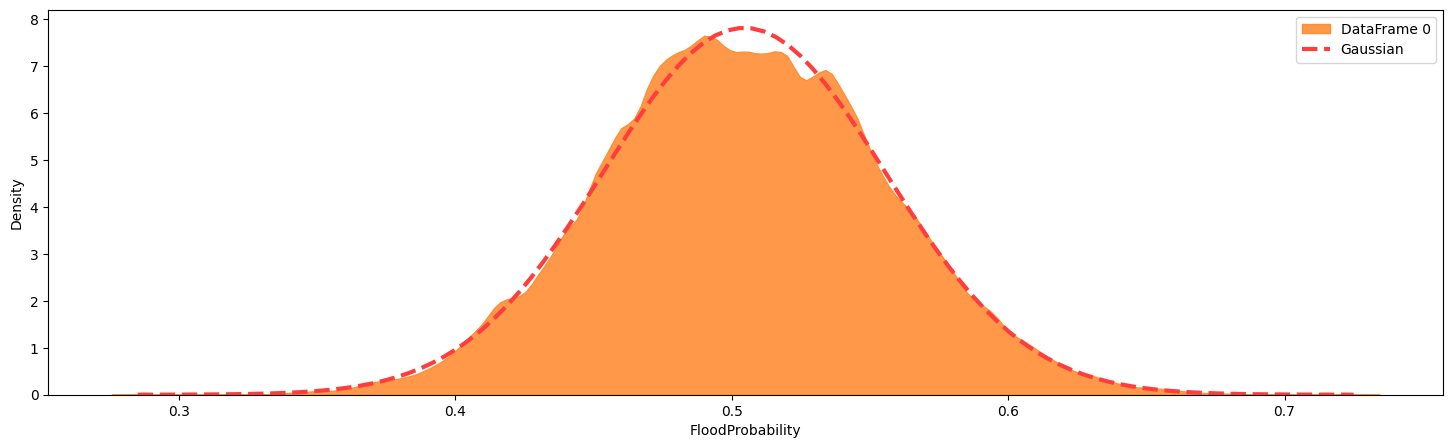

In [11]:
mean = df_train['FloodProbability'].mean()
std_dev = df_train['FloodProbability'].std()
x = np.linspace(df_train['FloodProbability'].min(), df_train['FloodProbability'].max(), 100)
y = norm.pdf(x, mean, std_dev)

plt.figure(figsize=(18, 5))
ax = plt.subplot(111)
target_distrib = utilities.plot_kde(ax, df_train, column='FloodProbability', color=COLORS['ORANGE'], fill=True)
plt.plot(x, y, color=COLORS['RED'], linestyle='--', label='Gaussian', linewidth=3)

plt.legend()
plt.show()

The target distribution seems to match a gaussian distribution.

We then check the correlation between the features:

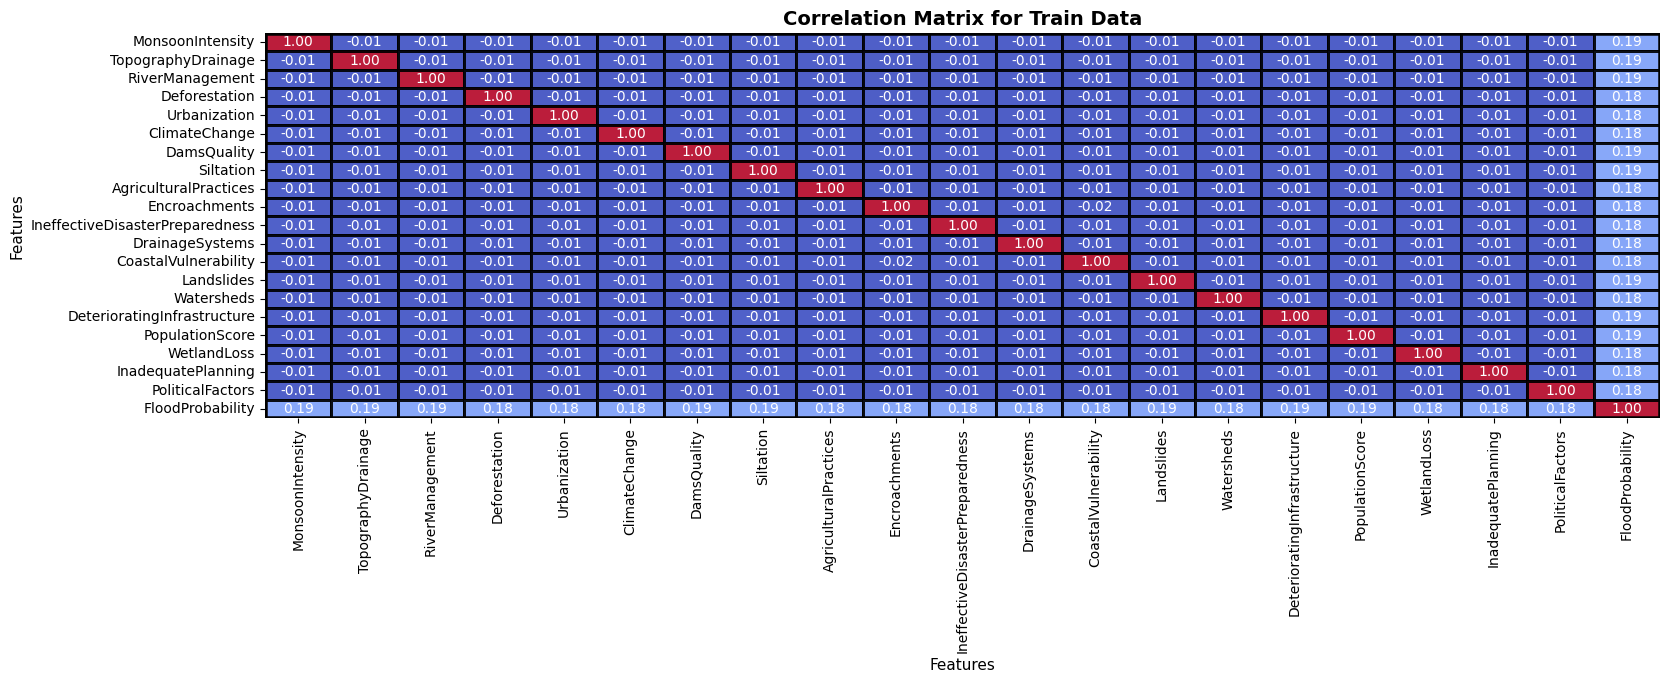

In [12]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(111)
corr_matrix = utilities.plot_correlation_matrix_heatmap(ax, df_train.drop(columns=['id']), 
                                                        title='Correlation Matrix for Train Data', cmap='coolwarm',
                                                        rotation=90)

The features are not correlated with each other.

### <span style="color:#800080; font-style:italic; font-family:Arial;">Feature Engineering</span>

In [13]:
# Sum all features in one column
df_train['sum_all'] = df_train.drop(columns=['id', 'FloodProbability']).sum(axis=1)
df_test['sum_all']  = df_test.drop(columns=['id']).sum(axis=1)

In [14]:
df_train

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability,sum_all
0,0,5,8,5,8,6,4,4,3,3,...,3,3,5,4,7,5,7,3,0.445,94
1,1,6,7,4,4,8,8,3,5,4,...,2,0,3,5,3,3,4,3,0.450,94
2,2,6,5,6,7,3,7,1,5,4,...,3,7,5,6,8,2,3,3,0.530,99
3,3,3,4,6,5,4,8,4,7,6,...,4,7,4,4,6,5,7,5,0.535,104
4,4,5,3,2,6,4,4,3,3,3,...,2,6,6,4,1,2,3,5,0.415,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,1117952,3,3,4,10,4,5,5,7,10,...,8,7,2,2,1,4,6,4,0.495,99
1117953,1117953,2,2,4,3,9,5,8,1,3,...,4,4,3,7,4,9,4,5,0.480,96
1117954,1117954,7,3,9,4,6,5,9,1,3,...,5,5,5,6,5,5,2,4,0.485,98
1117955,1117955,7,3,3,7,5,2,3,4,6,...,8,5,3,4,6,7,6,4,0.495,99


### <span style="color:#800080; font-style:italic; font-family:Arial;">Training some models</span>

In [15]:
scaler = StandardScaler()
X = df_train.drop(columns=['id', 'FloodProbability'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, df_train['FloodProbability'], test_size=0.2, random_state=42)

In [17]:
# Scale
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
R2 = {}

In [19]:
# Use Linear Regression to make predictions
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

R2['Linear Regression'] =  r2_score(y_test, y_pred)
print(f'R2 for Linear Regression: {R2["Linear Regression"]}')

R2 for Linear Regression: 0.8448776302091098


##### <span style="color:#A8E4A0; font-style:italic; font-family:Arial;">XGB (optuna optimized)</span>

In [20]:
if BASE_XGB:
    xgb_params = {'max_depth': 9, 'learning_rate': 0.0252096665329469, 
                  'n_estimators': 416, 'min_child_weight': 10, 
                  'subsample': 0.5826927554432498, 'colsample_bytree': 0.9927232615829975}
    
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    R2['XgBoost'] = r2_score(y_test, y_pred)
    print(f'R2 for XgBoost: {R2["XgBoost"]}')
    
else:
    def objective_xgb(trial):
        param = {
            'booster': 'gbtree',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        model = XGBRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        return r2

    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective_xgb, n_trials=50)
    R2['XgBoost'] = study_xgb.best_value
    print(f'Best R2 for XgBoost: {R2["XgBoost"]}')
    print(f'Best hyperparameters for XgBoost: {study_xgb.best_params}')

R2 for XgBoost: 0.8674579254764553


##### <span style="color:#A8E4A0; font-style:italic; font-family:Arial;">CatBoost (optuna optimized)</span>

In [21]:
if BASE_CAT:
    cat_params = {'depth': 7, 'learning_rate': 0.18870612822875277, 
                  'iterations': 755, 'l2_leaf_reg': 8.995316500099186, 'border_count': 104}
    
    cat = CatBoostRegressor(verbose=0, **cat_params)
    cat.fit(X_train, y_train)
    y_pred = cat.predict(X_test)

    R2['CatBoost'] = r2_score(y_test, y_pred)
    print(f'R2 for CatBoost: {R2["CatBoost"]}')

else:
    def objective_cat(trial):
        param = {
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
            'border_count': trial.suggest_int('border_count', 32, 255)
        }

        model = CatBoostRegressor(verbose=0, **param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        return r2

    study_cat = optuna.create_study(direction='maximize')
    study_cat.optimize(objective_cat, n_trials=50)
    R2['CatBoost'] = study_cat.best_value
    print(f'Best R2 for CatBoost: {R2["CatBoost"]}')
    print(f'Best hyperparameters for CatBoost: {study_cat.best_params}')

R2 for CatBoost: 0.8673381665019297


##### <span style="color:#A8E4A0; font-style:italic; font-family:Arial;">LGBM (optuna optimized)</span>

In [22]:
if BASE_LGB:
    lgb_params = {'num_leaves': 252, 'learning_rate': 0.023626609978874134, 
                  'n_estimators': 314, 'min_child_weight': 5.167891994981192, 
                  'subsample': 0.5764056154472382, 'colsample_bytree': 0.9852937994372131}

    lgb = LGBMRegressor(**lgb_params)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict(X_test)

    R2['LightGBM'] = r2_score(y_test, y_pred)
    print(f'R2 for LightGBM: {R2["LightGBM"]}')

else:
    def objective_lgbm(trial):
        param = {
            'num_leaves': trial.suggest_int('num_leaves', 31, 256),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }

        model = LGBMRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        return r2

    study_lgbm = optuna.create_study(direction='maximize')
    study_lgbm.optimize(objective_lgbm, n_trials=50)
    R2['LightGBM'] = study_lgbm.best_value
    print(f'Best R2 for LightGBM: {R2["LightGBM"]}')
    print(f'Best hyperparameters for LightGBM: {study_lgbm.best_params}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 21
[LightGBM] [Info] Start training from score 0.504480
R2 for LightGBM: 0.8676804455551087


In [23]:
# # Use gradient boosting to make predictions
# gbr = GradientBoostingRegressor()
# gbr.fit(X_train, y_train)
# y_pred = gbr.predict(X_test)

# R2['Gradient Boosting'] = r2_score(y_test, y_pred)
# print(f'R2 for Gradient Boosting: {R2["Gradient Boosting"]}')

In [24]:
# # Use Random Forest to make predictions
# rf = RandomForestRegressor()
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)

# R2['Random Forest'] = r2_score(y_test, y_pred)
# print(f'R2 for Random Forest: {R2["Random Forest"]}')

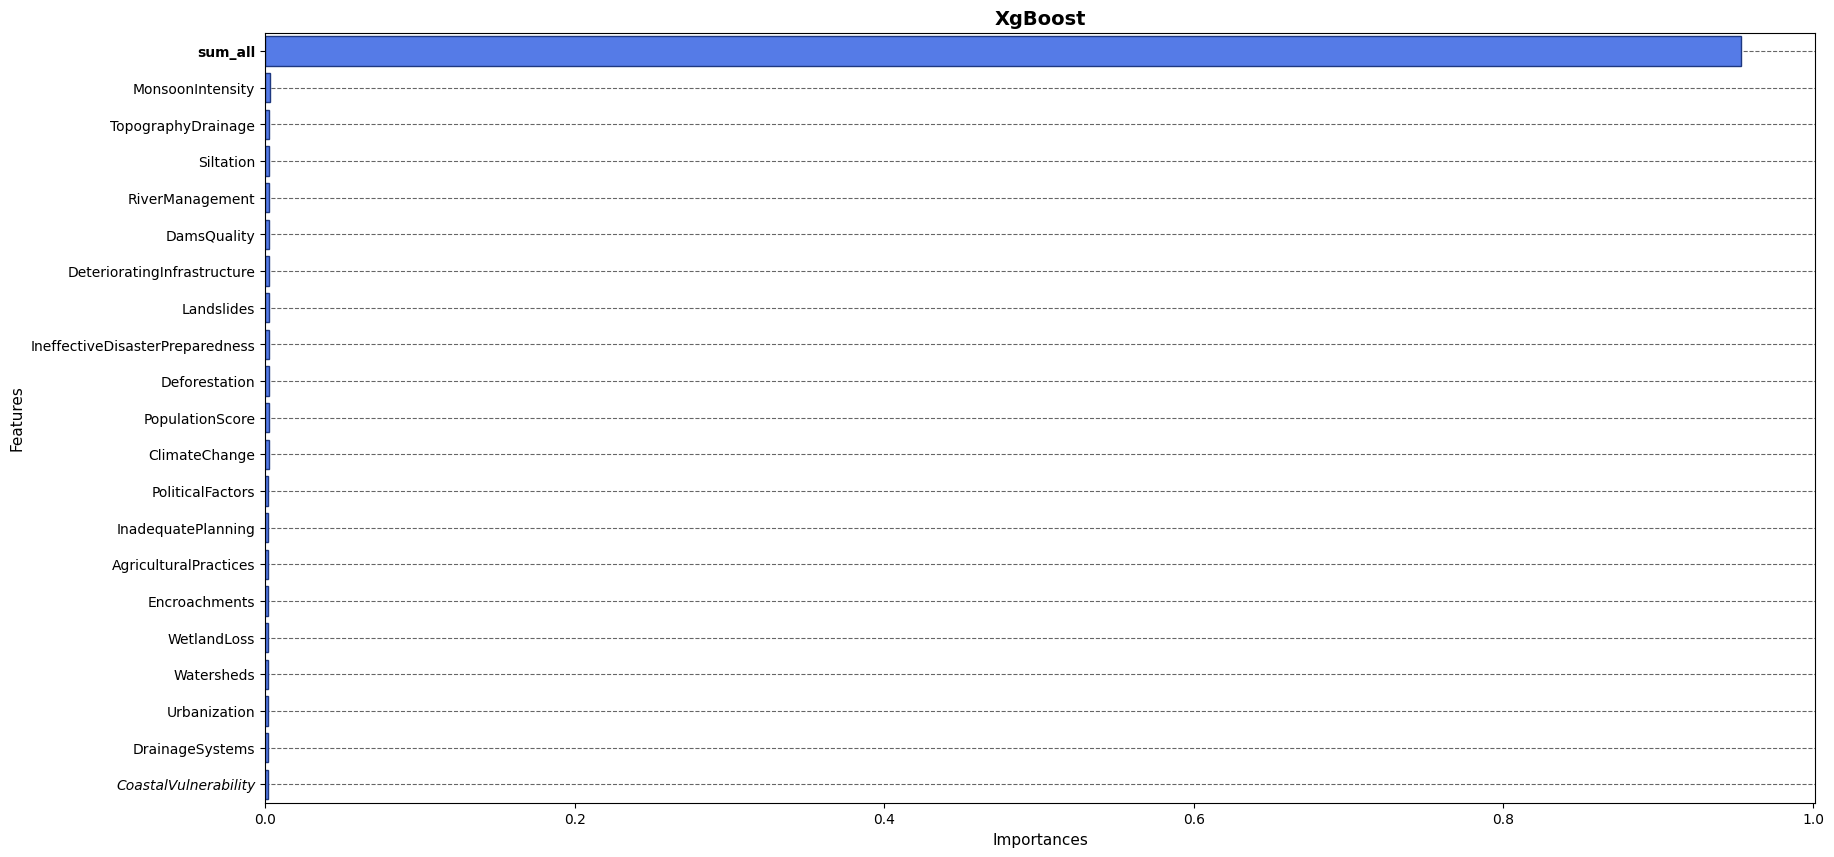

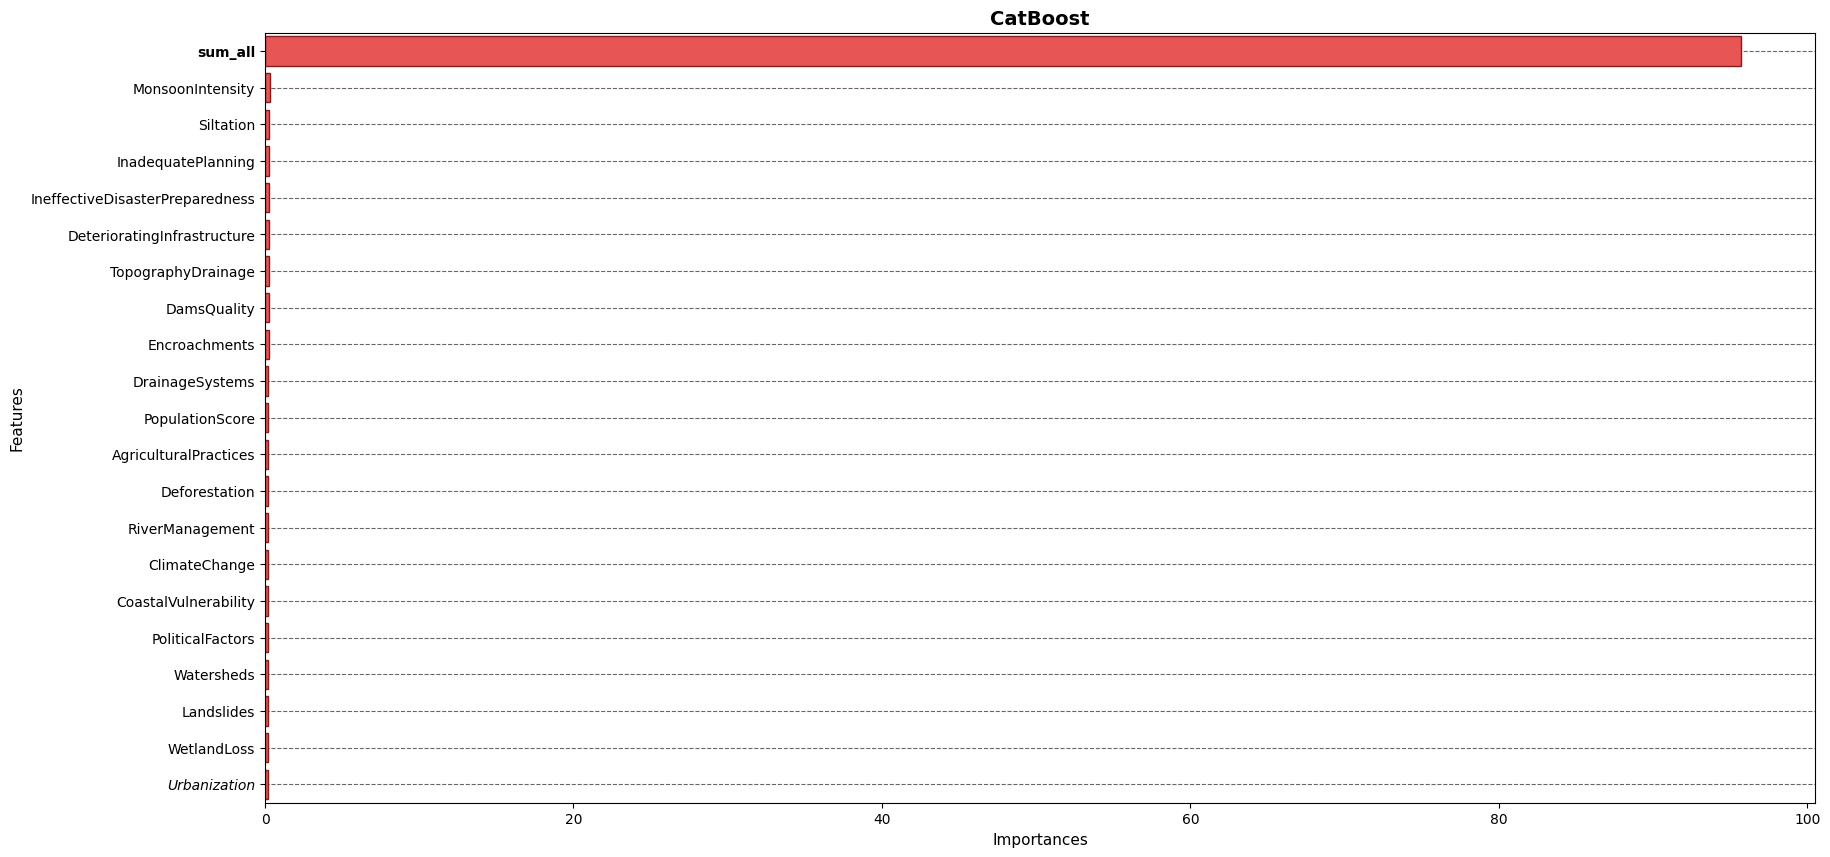

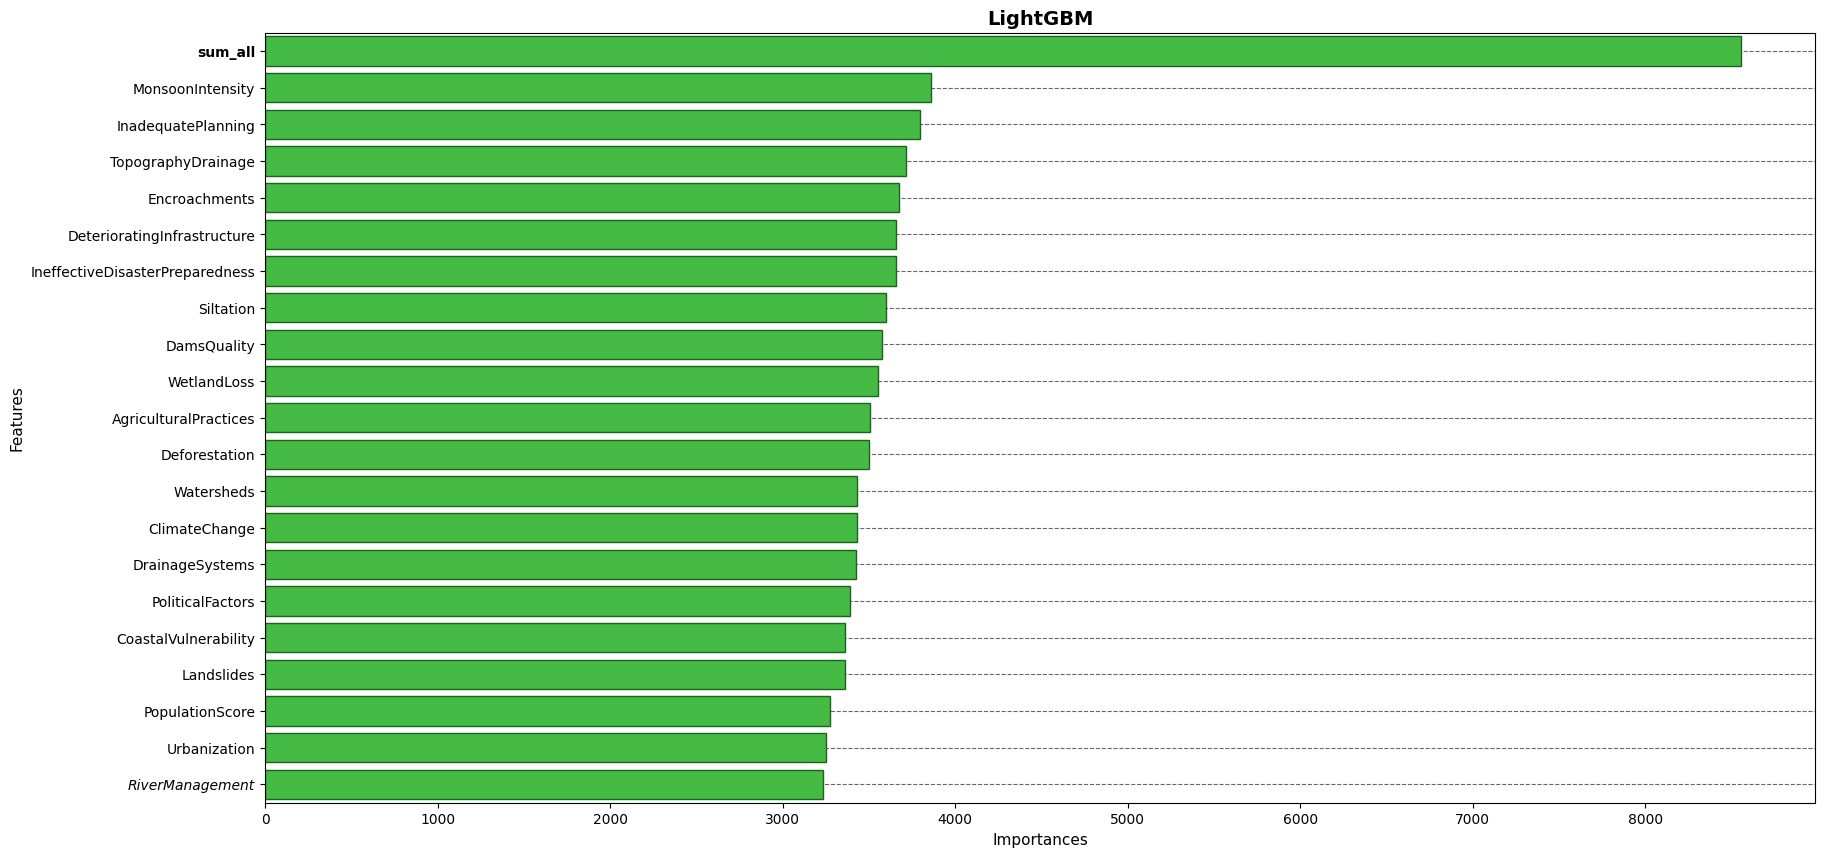

In [33]:
# Get features importance
features = X.columns
importances_xgb = xgb.feature_importances_
importances_cat = cat.feature_importances_
importances_lgb = lgb.feature_importances_

plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
utilities.plot_feature_importance(ax, features, importances_xgb, title='XgBoost', color=COLORS['BLUE'])
plt.show()

plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
utilities.plot_feature_importance(ax, features, importances_cat, title='CatBoost', color=COLORS['RED'])
plt.show()

plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
utilities.plot_feature_importance(ax, features, importances_lgb, title='LightGBM', color=COLORS['GREEN'])
plt.show()


In [25]:
# Stack all models
estimators = [
    ('xgb', xgb),
    ('cat', cat),
    ('lgb', lgb)
]

stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

R2['Stacking'] = r2_score(y_test, y_pred)
print(f'R2 for Stacking: {R2["Stacking"]}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 446
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 21
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 440
[LightGBM] [Info] Number of data points in the train set: 715492, number of used features: 21
[LightGBM] [Info] Start training from score 0.504504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 715492, number of used features: 21
[LightGBM] [Info] Start tra

In [26]:
# Generate csv file
X = df_train.drop(columns=['id', 'FloodProbability'])
y = df_train['FloodProbability']

X = scaler.fit_transform(X)
X_test = scaler.transform(df_test.drop(columns=['id']))

stack.fit(X, y)
y_pred = stack.predict(X_test)

df_test['FloodProbability'] = y_pred
df_test[['id', 'FloodProbability']].to_csv('submission.csv', index=False)

print('Submission file created!')